# biLSTM Functions

#TOD0:

weighted_mse_test_11 --> weighted_mse_test

weighted_mse_*_11 -> weighted_mse_*_11

# ===============================================
# IMPORT +++++
#

In [40]:
import pandas as pd
import numpy as np
import time
import random
from string import ascii_letters, ascii_lowercase

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from scipy.stats import mode

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
! pwd

/Users/michal/diploma/Hi-ChIP-ML/tutorials


# Functions

In [42]:
# sequenc_len_list = [6]
# num_lstm_units = 6
# verbose=True
# do_only_1_feature_exps = False
# do_drop_1_feature_exps = False
# do_all_together = True

def main_analysis(data_path,  cell_line, bioset, num_experements, 
                  sequenc_len_list = [6], num_lstm_units = 6, 
                  batch_size = 160, num_folds = 4,
                  do_only_1_feature_exps = True, do_drop_1_feature_exps = True,
                  do_all_together = False, use_chr_onehotenc=True,
                  use_coord_scale=True, 
                  verbose=True,
                 ):


    data_original = load_data(data_path, index_col=0, verbose=verbose)
    data = proccess_data(data_original, cell_line, bioset, 
                         use_chr_onehotenc=use_chr_onehotenc,
                         use_coord_scale=use_coord_scale)

    target_original, target = get_target(target_path, cell_line, verbose=verbose)
    #     data_scaled_clean, target_clean, empty_chr_names, num_empty_bins = data, target, [], [] # cleanDataTarget(data, target)
    target_clean = target['gamma']  # target_clean[['gamma']]

    data_scaled_clean, target_clean = data, target_clean

    if verbose:
        print('data_original.head =', data_original.head())
        print('proccessed data.head =', data.head())
        print('proccessed data.shape =', data.shape)

        print('target_original.head =', target_original.head())
        print('proccessed target.shape =', target.shape)

        print('data_scaled_clean.shape, target_clean.shape =', data_scaled_clean.shape, target_clean.shape)



    # Features correlation matrix
    d = data_original.copy()
    d['target'] = target_original.gamma
    corrs = correlationHeatmap(d, title="Features correlation - Original - c.l. " + cell_line)

    d = data_scaled_clean.copy()
    d['target'] = target_clean # gamma
    corrs = correlationHeatmap(d, title="Features correlation - scaled - c.l. " + cell_line)



    eval_models_df = pd.DataFrame(columns=["exper_num", "sequenc_len", "num_lstm_units", "n_epochs",
                                   "weighted_mse_test_11", "weighted_mse_train_11", "weighted_mse_val_11",
                                   "weighted_mse_test_const_11",
                                   "batch_size", "duration",
                                   "missing_feature"]) # , 'feature']) 

    eval_models_df_1, eval_models_df_drop, feature_score_1, feature_score_drop = train_1_and_drop(data_scaled_clean=data_scaled_clean,
                                                         target_clean=target_clean,
                                                         eval_models_df=eval_models_df, 
                                                         sequenc_len_list =  sequenc_len_list,
                                                         num_lstm_units = num_lstm_units,
                                                         batch_size=batch_size,
                                                         n_epochs_max = n_epochs_max, 
                                                         num_experements = num_experements,
                                                         num_folds = num_folds,
                                                         file_path = file_path, 
                                                         random_state = random_state,
                                                         do_only_1_feature_exps = do_only_1_feature_exps,
                                                         do_drop_1_feature_exps = do_drop_1_feature_exps)

    mean_test_together, std_test_together = None, None
    if do_all_together:
    #         print('\n-----\n use all FEATURES -- ' + len(data_scaled_clean) + '\n-----\n')
        # Use all features
        eval_models_df_together = pd.DataFrame(columns=["exper_num", "sequenc_len", "num_lstm_units", "n_epochs",
                                   "weighted_mse_test_11", "weighted_mse_train_11", "weighted_mse_val_11",
                                   "weighted_mse_test_const_11",
                                   "batch_size", "duration",
                                   "missing_feature"]) 
        get_full_model_experiments(
            data_scaled_clean, target_clean, eval_models_df_together, 
            sequenc_len_list =  sequenc_len_list ,#
            num_lstm_units = num_lstm_units,
            batch_size=batch_size,
            n_epochs_max = n_epochs_max, 
            num_experements = num_experements,
            num_folds = num_folds,
            file_path = file_path, 
            missing_feature = -1)

        mean_test_together = eval_models_df_together[eval_models_df_together['exper_num'] == 'mean']['weighted_mse_test_11']
        std_test_together = eval_models_df_together[eval_models_df_together['exper_num'] == 'std']['weighted_mse_test_11']



    
    return eval_models_df_1, eval_models_df_drop, eval_models_df_together, \
             mean_test_together, std_test_together, feature_score_1, feature_score_drop, \
            data_scaled_clean, target_clean, 


In [43]:
def plotData(data, ncols, nrows, method = 'hist', is_sharex=True, share_axes='y', bins=50, 
             plt_title='Histograms of data features', figsize=(20, 18), 
             cmin=None, cmax=None, min_val=None, max_val=None,
             verbose=False, fig=None, axes=None, alpha=0.6):
    if (min_val is None or  max_val is None):
        min_val, max_val = min(np.min(data)) - 3, max(np.max(data))
    if (fig is None or axes is None):
        if (share_axes == 'xy'):
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, 
                                     sharex='all', sharey='all')
        else:
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize,
                                     sharex=is_sharex)
    fig.set_figheight(24)
    i = 0
    for row in range(nrows):
        if i >= len(data.columns):
                break      
        for col in range(ncols):
            if i >= len(data.columns):
                break
            axes[row][col].set_title(data.columns[i], fontsize=22)       
            if method == "hist":
                if (cmin is not None and  cmax is not None):
                    axes[row][col].hist(data[[data.columns[i]]].values, bins=bins, range=(cmin, cmax), alpha=0.6, label=plt_title) # cmin=cmin, cmax=cmax)
                else:
                    axes[row][col].hist(data[[data.columns[i]]].values, bins=bins, alpha=alpha, label=plt_title) # cmin=cmin, cmax=cmax)
                if is_sharex or share_axes == 'xy':
                    axes[row][col].set_xlim(min_val, max_val)
                
            elif method == "original":
                axes[row][col].scatter(np.arange(0, data.shape[0]), data[[data.columns[i]]].values,)
                if is_sharex or share_axes == 'xy':
                    axes[row][col].set_ylim(min_val, max_val)
                    
            if verbose:
                print(i)   
                print(data[[data.columns[i]]].mean(), data[[data.columns[i]]].std(), data[[data.columns[i]]].min(), data[[data.columns[i]]].max())
            i += 1
    plt.suptitle(plt_title, fontsize=30, y=0.92)
#     return fig, axes   


def correlationHeatmap(data, title="Features corrselation - scaled", figsize=(11, 9)):
    sns.set(style="white")
    
    # Generate a large random dataset
    rs = np.random.RandomState(33)
    # Compute the corrselation matrix
    corrs = data.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # # Draw the heatmap with the mask and corrsect aspect ratio
    # sns.heatmap(corrs, mask=mask, cmap=cmap, vmax=.3, center=0,
    #             square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.heatmap(corrs, cmap=cmap, square=True, linewidths=.5, 
                cbar_kws={"shrink": .5})
    ax.set_title(title)
    plt.show()

    g = sns.clustermap(corrs,     
                       cmap = sns.diverging_palette(220, 10, as_cmap=True) ) 
    plt.title("Features corrselation - scaled sorted - c.l." + cell_line)
    plt.show()
    print(corrs['target'], corrs.index[np.argsort(corrs['target'])])
    return(corrs)



def OneHotEncode(data_feature, feature_preffix="", verbose=True):
    # Integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(data_feature.values)
    # Binary encode
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    onehot_df = pd.DataFrame(onehot_encoded, 
                             columns = feature_preffix + label_encoder.classes_, 
                             index = data_feature.index )
    if verbose: 
        print("values: ", data_feature.values)
        print("integer values: ", integer_encoded.shape, integer_encoded)
        print("one-hot values: ", onehot_encoded.shape, onehot_encoded)
        ## Invert first example
        # inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
        # print("inversed of ", data_feature[0], " is ", inverted)
    return onehot_df, onehot_encoder, label_encoder
 


def load_data(data_path, index_col=0, verbose=True):
    data = pd.read_csv(data_path, index_col=index_col)
    if verbose:
        print('data.shape = ', data.shape)
        # print(data.head())
        print('column names =', data.columns.values)
    return(data)

def proccess_data(data_original, 
                  cell_line, 
                  bioset, 
                  do_scaling=True,
                  use_chr_onehotenc=True, 
                  use_coord_scale=True,
                  do_plots=True,
                  coord_scale_const=10000000,
                  verbose=True,
                 ):
    ''' Proccess data
         - Drop 'chrN', 'start_coord'
         - Use Biological Dataset if defined
         - Use 1 Cell Line if cell_line is not 'all'
         - Scaling for the non-binary data (specified in the list of features) if do_scaling=True
         - One Hot Encoding of the Chromasome Number feature 'ChrN' if use_chr_onehotenc=True
         - Start coordinate number of the bin scale: devide by const
         - Plot original and proccessed features if do_plots=Trues
         
    '''
    data = data_original.copy()
    
    if bioset:
        data = data[bioset]
        print("Using features bioset:", bioset)
    
    if cell_line != 'all':
        data = data[data[cell_line] == 1]
        data = data.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
        print("Using cell line:", cell_line)

    if do_scaling:
        features_to_scale = data.columns[[f not in ['chrN', 
                                                    'start_coord', 
                                                    'is_s2', 'is_kc', 'is_bg'] for f in data.columns]]
        data[features_to_scale] = preprocessing.scale(data[features_to_scale],
                                          axis=0, with_mean=True, with_std=True)
        print("Scaling of the features:", features_to_scale)
    
    if use_chr_onehotenc:
        onehot_df_chr, onehot_encoder, label_encoder = OneHotEncode(data['chrN'], 
                                                            feature_preffix="", 
                                                            verbose=False)
        data = pd.concat([onehot_df_chr, data.drop(['chrN'], axis=1)], axis=1)
        print("Using chromosome One Hot Encoding:", np.unique(data_original['chrN']))
    else:  
        # drop chrN column - not to work with strings
        data = data.drop(['chrN'], axis=1)
        
        
    if use_coord_scale:
        data[['start_coord']] = data[['start_coord']] / coord_scale_const
        
    if verbose:
#         print('proccessed data.head =', data.head())
        print('proccessed data.shape =', data.shape)
    
    
    # Plot features 
    if do_plots:
        ncols = 3
        nrows = data_original.shape[1] // ncols + 1
        plotData(data_original[data_original.columns[data_original.columns != 'chrN']],
                 ncols, nrows, bins=30, method = 'original', figsize=(20, 10),
                 is_sharex=False, plt_title='Original data features (ChIP-Seq) - c.l.' + cell_line)
        plotData(data_original[data_original.columns[data_original.columns != 'chrN']], ncols, nrows, 
                 bins=30, method = 'hist', is_sharex = False, 
                 plt_title='Histograms of original data features - c.l. ' + cell_line)


        nrows = data.shape[1] // ncols + 1
        plotData(data, ncols, nrows, bins=30, method = 'original', figsize=(20, 10),
                 is_sharex=False, plt_title='Proccessed data features (ChIP-Seq) - c.l. ' + cell_line)
        plotData(data, ncols, nrows, bins=30, method = 'hist', is_sharex = True, 
                 plt_title='Histograms of proccesed data features - c.l. ' + cell_line)

    return data

# def load_target(target_path):
#     target = pd.read_csv(target_path, index_col=0)
#     if cell_line:
#         target = target[target[cell_line] == 1]
#         target = target.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
#     print('target.shape =', target.shape)
#     print('target.column =', target.columns)
#     target.head()


def get_target(target_path, cell_line, verbose=True):
    target_original = pd.read_csv(target_path, index_col=0)
    
    if cell_line != 'all':
        target = target_original[target_original[cell_line] == 1]
        target = target.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
    else:
        target = target_original.copy()  

    if verbose:
        print('original target.shape =', target_original.shape)
        print('target.columns =', target_original.columns)
        target_original.head()

        print('target.shape =', target.shape)
        print('target.column =', target.columns)
        target.head()

    return target_original, target
    


def findEmptyChr(data, verbose=True):
    '''Find empty chromosoms.'''
    chr_names = np.unique(data['chrN'])
    empty_chr_names = []
    num_empty_bins = 0

    for chr_i in chr_names:
        gamma_sum = sum(data[data.chrN == chr_i].gamma)
        if (verbose):
            print("---\nChr name =", chr_i)
            print("Sum of gamma values =", gamma_sum)
            print("Number of bins =", len(data[data.chrN == chr_i]))

        if (gamma_sum == 0):
            empty_chr_names.append(chr_i)
            num_empty_bins += len(data[data.chrN == chr_i])
    print("===")
    print("Total num of chr =", len(chr_names), "\n", chr_names)
    print("Num of empty chr =", len(empty_chr_names), "\n", empty_chr_names)
    print("Total num of chr =", len(data.index))
    print("Num of empty bins =", num_empty_bins)
    
    return(empty_chr_names, num_empty_bins)


def cleanDataTarget(data, target, ncols = 3, do_plots=True, verbose=True):
    ''' Remove empty (zeros) chromosomes from data and target '''
    
    empty_chr_names, num_empty_bins = findEmptyChr(target, verbose)
    
    if num_empty_bins > 0:
        data_scaled_clean = data[~target.chrN.isin(empty_chr_names)]
        target_clean = target[~target.chrN.isin(empty_chr_names)]
    
    # Plot features 
    if do_plots:
        nrows = data_scaled_clean.shape[1] // ncols 
        plotData(data_scaled_clean, ncols, nrows, bins=30, method = 'original', figsize=(20, 10),
                 is_sharex=False, plt_title='Clean proccessed data features (ChIP-Seq) - c.l. ' + cell_line)
        plotData(data_scaled_clean, ncols, nrows, bins=30, method = 'hist', is_sharex = True, 
                 plt_title='Histograms of clean proccessed data features - c.l. ' + cell_line)
        
    return (data_scaled_clean, target_clean, empty_chr_names, num_empty_bins)




# ====================================================================== 
# FULL Experiment FUNCTIONS

In [44]:
def split_data_middle_target(data, target, sequenc_len = 6, overlop_len = 1, 
                             random_state=16, test_size=0.3, val_size=0.3, shuffle=True):
    '''
    для последовательности мы предсказываем значение целой переменной "центрального" элемента.
    по формуле: int(seq_lenght / 2 ) ( - 1 - т.к. индексация с нуля )
    округление вниз до ближайшего целого
    =>
    То есть в последовательности длины 7, мы каждый раз предсказываем значение 3-го элемента.

    в последовательности длины 6, мы каждый раз предсказываем значение 3-го элемента.

    в последовательности длины 5, мы каждый раз предсказываем значение 2-го элемента.

    в последовательности длины 9, мы каждый раз предсказываем значение 4-го элемента.

    =>
    if random_state is None - shuffel the splitting
    '''
    mid_indx = max(int(sequenc_len/2 + 0.5)-1, 0)
    
    sequenc_data = []
    sequenc_targets = []

    for obj_i in range(len(data)  - sequenc_len + 1):
        sequenc_data.append(data[obj_i: obj_i + sequenc_len]) 
        sequenc_targets.append(target[obj_i + mid_indx] )
#     print(len(sequenc_data))
#     print(len(sequenc_data[16]))
#     print(sequenc_data)
#     print(X.shape, y.shape)

    sequenc_data = np.array(sequenc_data)
    sequenc_targets = np.array(sequenc_targets)
    X, y = sequenc_data, sequenc_targets 

    if (random_state is None):
        # if random_state is None - shuffel the splitting
        random_state = random.randint(0, 10000)
    
    # split and mix learning samples
    X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=test_size, 
                                                        random_state=random_state, shuffle=shuffle)
    
    X_test, X_val, y_test, y_val = train_test_split(X_test[:], y_test[:], test_size=val_size,
                                                    random_state=random_state, shuffle=shuffle)
    
    print('X_train.shape, X_test.shape, y_train.shape, y_test.shape =',
          X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    return X_train, X_test, X_val, y_train, y_test, y_val, sequenc_data, sequenc_targets

In [45]:

# def weighted_mse(y_true, y_pred):
#     diff2 = (y_true - y_pred)**2 * (11 - y_true)
#     return K.mean(diff2, axis = -1)

def weighted_mse(y_true, y_pred, const_scale=11):   
    diff = ((y_true - y_pred)**2) * (const_scale - y_true) / const_scale # / 11
    return  K.mean(diff)  # K.mean(K.sum(diff, axis = -1)) # 

def mae_cout(y_true, y_pred):
    y_pred = np.hstack(y_pred)
    
    return np.mean(np.abs(y_true - y_pred))

def rmse_cout(y_true, y_pred):
    y_pred = np.hstack(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def weighted_mse_cout(y_true, y_pred, const_scale=11):
    y_pred = np.hstack(y_pred)
    return np.mean(((y_true - y_pred)**2) * (const_scale - y_true)) / const_scale  # / 11 ) 

def count_errors_by_target_grid(y_true, y_pred, const_scale=11):
    if (len(y_true) != len(y_pred)):
         return "ERROR of prediction and true size"
    
    mae_errors_by_grid = np.array([0]*const_scale, dtype=float)    
    rmse_errors_by_grid = np.array([0]*const_scale, dtype=float)    
    weig_mse_errors_by_grid = np.array([0]*const_scale, dtype=float)
    objs_by_grid = np.array([0]*const_scale, dtype=float)

    for i in range(len(y_true)):  # K.int_shape(y_true)):
        mae_errors_by_grid[int(y_true[i])] += np.abs(y_true[i] - y_pred[i]) # (y_true[i] - y_pred[i])**2 # mse
        rmse_errors_by_grid[int(y_true[i])] += (y_true[i] - y_pred[i])**2 # mse
        weig_mse_errors_by_grid[int(y_true[i])] += (y_true[i] - y_pred[i])**2 * (const_scale - y_true[i]) 
        objs_by_grid[int(y_true[i])] += 1
      
    mae_errors_by_grid /= objs_by_grid
    rmse_errors_by_grid /= objs_by_grid
    rmse_errors_by_grid = np.sqrt(rmse_errors_by_grid)
    weig_mse_errors_by_grid /= objs_by_grid
    
    return mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, objs_by_grid


def plot_train_res(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss - weighted mse')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for MSE
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model mean squared error')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def count_plot_test_errors(model, x_test, y_test):
    y_pred_test = model.predict(x_test)
    print("test sizes = ", len(y_test), len(x_test), len(y_pred_test))

    mae_errors_by_grid, rmse_errors_by_grid, \
        weig_mse_errors_by_grid, objs_by_grid = count_errors_by_target_grid(y_test, y_pred_test)
    return mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, objs_by_grid


In [46]:
def biLSTM_Train_Test(x_train, x_test, x_val, y_train, y_test, y_val, \
                      
                        sequenc_data, sequenc_targets, \
                      
                        data, target, 
                       
                        sequenc_len = 6, \

                        num_lstm_units = 64, \

                        num_epochs=3, \

                        BATCH_SIZE = 32, \

                        num_features = 5, \
                      
                        min_delta = 0.000001, \

                        dropout_rat = 0.3, \
                      
                        patience = 5, \

                        opt_name = 'adam', \

                        loss = weighted_mse, \

                        metrics = [weighted_mse, 'mse'],

                        rnn_cell_type = "Bidirectional LSTM",

                        overlop_len = -1,
                        
                        output_size = 1,
                      
                        const_scale = 11,
        
                        random_state = 16):
    start_time = time.time()
    
    # BiLSTM RNN model:
    model = Sequential()
    model.add(Bidirectional(LSTM(num_lstm_units), input_shape=(sequenc_len, num_features)))
    model.add(Dropout(dropout_rat))
    model.add(Dense(output_size))
    
    # Define early stopping callback
    early_stopping_monitor = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience,
                                           verbose=1, mode='auto') # monitor='val_weighted_mse', mode='min', min_delta=0.000001)
    print('Train... with ')
    model.compile(opt_name, loss = loss, metrics = metrics)  # , mae_by_target_grid])
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=num_epochs,
                        validation_data=[x_val, y_val], 
                        callbacks=[early_stopping_monitor], 
                        verbose=False)
    # plot_train_res(history)
    n_epochs_past = len(history.history["loss"])
    
    # ------------ PREDICTION -------------------------------------------------------------
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)
    
    # -------------------------------------------------------------------------
    #          TEST PREDICTION Error
    # -------------------------------------------------------------------------
    weighted_mse_test = weighted_mse_cout(y_true = y_test, y_pred = y_pred_test, const_scale=const_scale)
    # -------------------------------------------------------------------------
    #          TRAIN PREDICTION Error
    # -------------------------------------------------------------------------
    weighted_mse_train = weighted_mse_cout(y_true = y_train, y_pred = y_pred_train, const_scale=const_scale)
    # -------------------------------------------------------------------------
    #          VAL PREDICTION Error
    # -------------------------------------------------------------------------
    weighted_mse_val = weighted_mse_cout(y_true = y_val, y_pred = y_pred_val, const_scale=const_scale)
    # -------------------------------------------------------------------------
    #          TEST Const Error
    # -------------------------------------------------------------------------
    const_pred = np.mean(y_train)
    const_pred_test = np.array([const_pred] * len(y_test))
    weighted_mse_test_const = weighted_mse_cout(y_true = y_test, 
                                                y_pred = const_pred_test, 
                                                const_scale=const_scale)

    # -- Duration --    
    end_time = time.time()
    duration = end_time - start_time 
    print("duration:", duration)
    
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model, \
                weighted_mse_test, weighted_mse_train, \
                weighted_mse_val, weighted_mse_test_const, \
                duration, n_epochs_past       

In [47]:
# Add colums

def add_columns(new_col_names, df):
    for col_name in new_col_names:
        df[col_name] = -1 + np.zeros_like(eval_models_df["model"])
    return df

# new_col_names = ["mae_errors_by_grid_const", "rmse_errors_by_grid_const", "weig_mse_errors_by_grid_const"]
# eval_models_df = add_columns(new_col_names, df=eval_models_df)

In [48]:
def get_full_model(data,
                   target,
                   eval_models_df,
                   sequenc_len_list=[6], 
                   num_lstm_units_list=[16], 
                   n_epochs_list= [63],  
                   missing_feature = -1,
                   file_path = "./eval_models_NN.csv", 
                   exper_num=0, 
                   batch_size = 160,
                   random_state = None,
                   num_folds = 4,
                   overlop_len = -1,
                   output_size = 1,
                   rnn_cell_type = "Bidirectional LSTM",
                   opt_name = 'adam',
                   dropout_rat = 0.3,
                  ):

    num_features = data.shape[-1]

    for sequenc_len_i in sequenc_len_list:
        for num_lstm_units in num_lstm_units_list: 
            for n_epochs in n_epochs_list:
                ''' make more n_epochs'''
                
                x_train, x_test, x_val, y_train, y_test, y_val, \
                    sequenc_data, sequenc_targets = split_data_middle_target(data.values, 
                                                                             target.values,
                                                                             sequenc_len = sequenc_len_i,
                                                                             overlop_len = overlop_len,
                                                                             random_state = random_state  # if random_state is None - shuffel the splitting
                                                                            )
                # K-folds:
                indexes = np.arange(0, sequenc_data.shape[0])
                kf = KFold(n_splits=num_folds, shuffle=True, random_state=16) # 3)
                k = 0
                for train_idxs, test_idxs in kf.split(indexes):
#                     print("%s %s" % (train_idxs, test_idxs))
                    test_idxs, val_idxs = train_test_split(test_idxs, 
                                                           test_size=0.3, 
                                                           random_state=random_state)
                    np.random.shuffle(train_idxs)
                    x_train = sequenc_data[train_idxs]
                    x_test = sequenc_data[test_idxs]
                    x_val = sequenc_data[val_idxs]

                    y_train = sequenc_targets[train_idxs]
                    y_test = sequenc_targets[test_idxs]
                    y_val = sequenc_targets[val_idxs]
                    
#                     print(sequenc_data[train_idxs].shape)
#                     print(sequenc_data[test_idxs].shape)
#                     print(sequenc_data[val_idxs].shape)
#                     print(sequenc_targets[train_idxs].shape)
#                     print(sequenc_targets[test_idxs].shape)
#                     print(sequenc_targets[val_idxs].shape)
#                     print("%s %s %s" % (train_idxs, val_idxs, test_idxs))
                    print('x_val.shape =', x_val.shape)
                    print('y_val.shape =', y_val.shape)
                    print('x_train.shape =', x_train.shape)
                    print('y_train.shape =', y_train.shape)
                    
                    model, \
                        weighted_mse_test, weighted_mse_train, weighted_mse_val, weighted_mse_test_const, \
                        duration, n_epochs_past = biLSTM_Train_Test(
                        
                                    x_train, x_test, x_val, y_train, y_test, y_val,
                        
                                    sequenc_data, sequenc_targets, 

                                    data, target, sequenc_len = sequenc_len_i,

                                    num_lstm_units = num_lstm_units, 

                                    num_epochs= n_epochs,

                                    BATCH_SIZE = batch_size,

                                    num_features = num_features,

                                    dropout_rat = dropout_rat,

                                    opt_name = opt_name,

                                    loss = weighted_mse,

                                    metrics = [weighted_mse, 'mse'],

                                    rnn_cell_type = rnn_cell_type,

                                    overlop_len = overlop_len,
                                    
                                    output_size = output_size,

                                    random_state = random_state)
                    
                    model_name = "bidirect LSTM input_window = " + str(sequenc_len_i)

#                     weighted_mse_test_11, weighted_mse_train_11, weighted_mse_val_11, weighted_mse_test_const_11 =\
#                         weighted_mse_test / 11., weighted_mse_train / 11., weighted_mse_val / 11., weighted_mse_test_const / 11.
                    weighted_mse_test_11, weighted_mse_train_11, weighted_mse_val_11, weighted_mse_test_const_11 =\
                        weighted_mse_test, weighted_mse_train, weighted_mse_val, weighted_mse_test_const

                    model_rezs = exper_num, sequenc_len_i, num_lstm_units, n_epochs_past, \
                        weighted_mse_test_11, weighted_mse_train_11, weighted_mse_val_11, weighted_mse_test_const_11,\
                        batch_size, duration, \
                        missing_feature

                    new_indx = eval_models_df.shape[0]
                    eval_models_df.loc[new_indx] = model_rezs
                    print("TEST WMSE = ", weighted_mse_test_11)
                    K.clear_session()
            
    print("TEST MEAN WMSE = ", weighted_mse_test_11)
    return model, \
                    weighted_mse_test, weighted_mse_train, weighted_mse_val, weighted_mse_test_const, \
                    duration, n_epochs_past,  \
                    eval_models_df, missing_feature


def get_full_model_experiments(data, 
                               target,
                               eval_models_df,
                               sequenc_len_list =  6, # [1, 5, 6, 8 ] ,# 
                               num_lstm_units = 64,
                               n_epochs_max = 46, #  2 # 
                               num_experements = 4,
                               file_path = "./eval_LSTM", #+data_csv,
                               missing_feature = -1, 
                               batch_size = 160,
                               random_state = None,
                              num_folds = 4):

    for sequenc_len_i in sequenc_len_list: 
        for exper_num in range(num_experements):
            K.clear_session()
            model, \
                weighted_mse_test, weighted_mse_train, weighted_mse_val, weighted_mse_test_const, \
                duration, n_epochs_past,  \
                eval_models_df, \
                missing_feature = get_full_model(data, target,
                           eval_models_df, 
                           sequenc_len_list=[sequenc_len_i], num_lstm_units_list=[num_lstm_units],
                           n_epochs_list = [n_epochs_max],  
                           missing_feature = missing_feature,
                           file_path = file_path,
                           exper_num = exper_num, 
                           batch_size = batch_size,
                           random_state = random_state,
                           num_folds = num_folds)
        
        new_indx = eval_models_df.shape[0]
        eval_models_df.loc[new_indx] = eval_models_df[new_indx - num_experements  * num_folds : new_indx ].mean(axis=0)
        eval_models_df["exper_num"][new_indx] = "mean"

        new_indx = eval_models_df.shape[0]
        eval_models_df.loc[new_indx] = eval_models_df[new_indx - num_experements  * num_folds : new_indx ].std(axis=0)
        eval_models_df["exper_num"][new_indx] = "std"


# RUN FULL EXPERIMENTS

In [49]:
def get_means_featured(data, eval_models_df, num_experements, num_folds, data_csv, do_save=True):

    # Set feature names
    features = np.hstack([data.columns, ['all']])
    print(eval_models_df, num_experements * num_folds, 
          np.hstack([[f]* (num_experements * num_folds + 2) for f in features]) )
    
    eval_models_df['feature'] = np.hstack([features[int(feat_idxs)] for feat_idxs in eval_models_df['missing_feature'].values]) # features[feat_idxs]
    # np.hstack([[f]* (num_experements * num_folds + 2) for f in features]) # features[feat_idxs]
    
    print('eval_models_df.shape, eval_models_df.columns =',
          eval_models_df.shape, eval_models_df.columns)

    print('data.columns.shape, data.columns', 
          data.columns.shape, data.columns)

    ## Means - from experiments
    eval_models_df_means = eval_models_df[eval_models_df['exper_num'] == 'mean']
    # eval_models_df[num_experements * num_folds::num_experements * num_folds+2]
   
    ### std
    eval_models_df_std =  eval_models_df[eval_models_df['exper_num'] == 'std']
#     eval_models_df[num_experements * num_folds +1::num_experements * num_folds+2]
#     stds = eval_models_df_std['weighted_mse_test_11']
#     exp_names = np.hstack([["All"], data_original.columns[2:]])
    
    if do_save:
        print(data_csv)
        eval_models_df.to_csv("../experiments/eval" + data_csv)
        data.to_csv("../experiments/data" + data_csv)
        eval_models_df_means.to_csv("../experiments/exp_means" + data_csv)
        eval_models_df_std.to_csv("../experiments/exp_stds" + data_csv)
        
    return eval_models_df_means, eval_models_df_std, eval_models_df

# def get_means_featured(data, eval_models_df, num_experements, num_folds, data_csv, do_save=True):

#     # Set feature names
#     features = np.hstack([data.columns, ['all']])
#     print(eval_models_df, num_experements * num_folds, 
#           np.hstack([[f]* (num_experements * num_folds + 2) for f in features]) )
    
#     eval_models_df['feature'] = np.hstack([features[int(feat_idxs)] for feat_idxs in eval_models_df['missing_feature'].values]) # features[feat_idxs]
#     # np.hstack([[f]* (num_experements * num_folds + 2) for f in features]) # features[feat_idxs]
    
#     print('eval_models_df.shape, eval_models_df.columns =',
#           eval_models_df.shape, eval_models_df.columns)

#     print('data.columns.shape, data.columns', 
#           data.columns.shape, data.columns)

#     ### Means - from experiments
#     eval_models_df_means = eval_models_df[num_experements * num_folds::num_experements * num_folds+2]
   
#     ### std
#     eval_models_df_std =  eval_models_df[num_experements * num_folds +1::num_experements * num_folds+2]
# #     stds = eval_models_df_std['weighted_mse_test_11']
# #     exp_names = np.hstack([["All"], data_original.columns[2:]])
    
#     if do_save:
#         print(data_csv)
#         eval_models_df.to_csv("../experiments/eval" + data_csv)
#         data.to_csv("../experiments/data" + data_csv)
#         eval_models_df_means.to_csv("../experiments/exp_means" + data_csv)
#         eval_models_df_std.to_csv("../experiments/exp_stds" + data_csv)
        
#     return eval_models_df_means, eval_models_df_std, eval_models_df


# def get_means_featured(data, eval_models_df, num_experements, num_folds, data_csv, do_save=True):

#     # Set feature names
#     features = np.hstack([data.columns, ['all']])
#     print(eval_models_df, num_experements * num_folds, 
#           np.hstack([[f]* (num_experements * num_folds + 2) for f in features]) )
    
#     eval_models_df['feature'] = np.hstack([[f]* (num_experements * num_folds + 2) for f in features]) # features[feat_idxs]
    
#     print('eval_models_df.shape, eval_models_df.columns =',
#           eval_models_df.shape, eval_models_df.columns)

#     print('data.columns.shape, data.columns', 
#           data.columns.shape, data.columns)

#     ### Means - from experiments
#     eval_models_df_means = eval_models_df[num_experements * num_folds::num_experements * num_folds+2]
   
#     ### std
#     eval_models_df_std =  eval_models_df[num_experements * num_folds +1::num_experements * num_folds+2]
# #     stds = eval_models_df_std['weighted_mse_test_11']
# #     exp_names = np.hstack([["All"], data_original.columns[2:]])
    
#     if do_save:
#         print(data_csv)
#         eval_models_df.to_csv("../experiments/eval" + data_csv)
#         data.to_csv("../experiments/data" + data_csv)
#         eval_models_df_means.to_csv("../experiments/exp_means" + data_csv)
#         eval_models_df_std.to_csv("../experiments/exp_stds" + data_csv)
        
#     return eval_models_df_means, eval_models_df_std, eval_models_df


def plot_exps_together(eval_models_df_means, eval_models_df_std):

    exps_grid = np.arange(eval_models_df_means.shape[0])
    fig, ax0 = plt.subplots(nrows=1, figsize=(16, 10))

    value_name = 'weighted_mse_test_11'  
    means = np.sort(eval_models_df_means[value_name])
    arg_sort_features = np.argsort(eval_models_df_means[value_name]).values
    
    stds = eval_models_df_std[value_name].values[arg_sort_features] # eval_models_df_std[value_name]
    ax0.errorbar(exps_grid, means, yerr=stds,  fmt='-o', label=value_name, color='g')
    
    # Test value using all data
    ax0.plot([means[0]]*means.shape[0], color='g' )

    value_name = 'weighted_mse_train_11'
    means = eval_models_df_means[value_name].values[arg_sort_features]
    stds = eval_models_df_std[value_name].values[arg_sort_features]
    ax0.errorbar(exps_grid, means, yerr=stds,  fmt='-o', label=value_name, color='b')
    # ax0.plot([means.values[-1]]*means.shape[0])

    value_name = 'weighted_mse_val_11' 
    means = eval_models_df_means[value_name].values[arg_sort_features]
    stds = eval_models_df_std[value_name].values[arg_sort_features]
    ax0.errorbar(exps_grid, means, yerr=stds,  fmt='-o', label=value_name, color='y', alpha=0.7)

    plt.legend(loc='lower left')

    features = eval_models_df_means['feature'].values  # list(data.columns.values) 
#     features.append('all_features')
#     features = np.array(features)
    features_sorted = features[arg_sort_features]
    [print(f) for f in features_sorted]

#     print('num_experements: ', num_experements)
    print('num_features: ', len(features))

    ax0.set_title(str(len(features))+' features - USE 1 -' + str(num_experements) +\
                  ' experiments (means,std) - C.L.' + cell_line + '\ntest features order', 
                  fontsize=18)
    # Set number of ticks for x-axis
    ax0.set_xticks(np.arange(means.shape[0]))
    # Set ticks labels for x-axis
    ax0.set_xticklabels(features_sorted, rotation='vertical', fontsize=18)

    plt.show()
    return features_sorted

    
def plot_exps_drops(eval_models_df_means, 
                    eval_models_df_std,
                    value_name = 'weighted_mse_train_11'):
    exps_grid = np.arange(eval_models_df_means.shape[0])
    fig, ax0 = plt.subplots(nrows=1, figsize=(16, 10))


    means = np.sort(eval_models_df_means[value_name])
    arg_sort_features = np.argsort(eval_models_df_means[value_name]).values
    stds = eval_models_df_std[value_name].values[arg_sort_features] # eval_models_df_std[value_name]

    features = eval_models_df_means['feature'].values #  list(data.columns.values) 
#     features.append('all_features')
#     features = np.array(features)
    features_sorted = features[arg_sort_features]

    len(features), features

    [print(f) for f in features_sorted]


    # print('data.columns.sorted:\n',
    #     features[np.argsort(eval_models_df_means[value_name]).values])
#     print('num_experements: ', num_experements)
    print('num_features: ', len(features))

    
    ax0.errorbar(exps_grid, means, yerr=stds,  fmt='-o', label=value_name)
    ax0.set_title(str(len(features)) +' features - USE 1 -' +
                  str(num_experements) + ' experiments (means,std) - C.L.' + 
                  cell_line + '\n' + value_name, 
                  fontsize=18)
    ax0.plot([means[0]]*means.shape[0])
    # Set number of ticks for x-axis
    ax0.set_xticks(np.arange(means.shape[0]))
    # Set ticks labels for x-axis
    ax0.set_xticklabels(features_sorted, rotation='vertical', fontsize=18)
    plt.legend(loc='lower left')
    plt.show()
    return(features_sorted)

    
def run_exps_use_1_features(data,
                            target,
                            eval_models_df, 
                            sequenc_len_list,
                            num_lstm_units,
                            n_epochs_max, 
                            num_experements,
                            num_folds, 
                            file_path, 
                            missing_feature,
                            batch_size,
                            random_state): 
    for out_feat_indx in range(data.shape[1]):
            K.clear_session()
            data_out1 = data[[data.columns[out_feat_indx]]].copy() 
            missing_feature = out_feat_indx    
            print('\n-----\n DROP FEATURE NUMBER -- ' + str(out_feat_indx) + '\n-----\n')
            get_full_model_experiments(
                data_out1, 
                target,
                eval_models_df, 
                sequenc_len_list =  sequenc_len_list,
                num_lstm_units = num_lstm_units,
                n_epochs_max = n_epochs_max, 
                num_experements = num_experements,
                num_folds = num_folds, 
                file_path = file_path, 
                missing_feature = missing_feature,
                batch_size = batch_size,
                random_state = random_state)

            eval_models_df.to_csv("../experiments/exps_1_feature" + data_csv)
            if out_feat_indx == data.shape[1]-1:    
                print('\n-----\n KEEP FEATURES -- ' + str(out_feat_indx) + '\n-----\n')
                # Use all features
                get_full_model_experiments(
                    data, target, eval_models_df, 
                    sequenc_len_list =  sequenc_len_list ,#
                    num_lstm_units = num_lstm_units,
                    n_epochs_max = n_epochs_max, 
                    num_experements = num_experements,
                    num_folds = num_folds, 
                    file_path = file_path, 
                    missing_feature = -1)
    return(eval_models_df)


def run_exps_drop_1_features(data,
                            target,
                            eval_models_df, 
                            sequenc_len_list,
                            num_lstm_units,
                            n_epochs_max, 
                            num_experements,
                            file_path, 
                            missing_feature,
                            batch_size,
                            num_folds, 
                            random_state): 
    for out_feat_indx in range(data.shape[1]):
            K.clear_session()
            data_out1 = data.copy()
            data_out1[data_out1.columns[out_feat_indx]] = 0
            missing_feature = out_feat_indx     

            print('\n-----\n DROP FEATURE NUMBER -- ' + str(out_feat_indx) + '\n-----\n')
            get_full_model_experiments(
                data_out1, 
                target,
                eval_models_df, 
                sequenc_len_list =  sequenc_len_list,
                num_lstm_units = num_lstm_units,
                n_epochs_max = n_epochs_max, 
                num_experements = num_experements,
                file_path = file_path, 
                missing_feature = missing_feature, # -1 #missing_feature,
                batch_size = batch_size,
                num_folds = num_folds, 
                random_state = random_state)
            eval_models_df.to_csv("../experiments/exps_drop_1_" + data_csv)

            if out_feat_indx == data.shape[1]-1:    
                print('\n-----\n KEEP FEATURES -- ' + str(out_feat_indx) + '\n-----\n')
                # Use all features
                get_full_model_experiments(
                    data, target, eval_models_df, 
                    sequenc_len_list =  sequenc_len_list ,#
                    num_lstm_units = num_lstm_units,
                    n_epochs_max = n_epochs_max, 
                    num_experements = num_experements,
                    num_folds =  num_folds, 
                    file_path = file_path, 
                    missing_feature = -1)
    return(eval_models_df)


def train_1_and_drop(data_scaled_clean,
                     target_clean,
                     eval_models_df, 
                     sequenc_len_list,
                     num_lstm_units,
                     n_epochs_max, 
                     num_experements,
                     file_path, 
                     batch_size,
                     num_folds, 
                     random_state,
                     do_only_1_feature_exps = True,
                     do_drop_1_feature_exps = True):
    eval_models_df_1, eval_models_df_drop = None, None
    feature_score_1, feature_score_drop = None, None
    
    if do_only_1_feature_exps:
        eval_models_df_1 = pd.DataFrame(columns=["exper_num", "sequenc_len", "num_lstm_units", "n_epochs",
                                   "weighted_mse_test_11", "weighted_mse_train_11", "weighted_mse_val_11",
                                   "weighted_mse_test_const_11",
                                   "batch_size", "duration",
                                   "missing_feature"]) 
        eval_models_df_1 = run_exps_use_1_features(data=data_scaled_clean,
                                                 target=target_clean,
                                                 eval_models_df=eval_models_df_1, 
                                                 sequenc_len_list =  sequenc_len_list,
                                                 num_lstm_units = num_lstm_units,
                                                 n_epochs_max = n_epochs_max, 
                                                 num_experements = num_experements,
                                                 file_path = file_path, 
                                                 missing_feature = -1, # missing_feature,
                                                 batch_size = batch_size,
                                                 random_state = random_state)

        eval_models_df_means, eval_models_df_std, eval_models_df = get_means_featured(data_scaled_clean, 
                                                                                      eval_models_df_1, 
                                                                                      num_experements,
                                                                                      num_folds, 
                                                                                      data_csv, 
                                                                                      do_save=True)
        plot_exps_together(eval_models_df_means, eval_models_df_std)
        plot_exps_drops(eval_models_df_means, eval_models_df_std, value_name = 'weighted_mse_train_11')
        plot_exps_drops(eval_models_df_means, eval_models_df_std, value_name = 'weighted_mse_test_11')
        

        value_name = 'weighted_mse_test_11'
        means = np.sort(eval_models_df_means[value_name])
        arg_sort_features = np.argsort(eval_models_df_means[value_name]).values
        # stds = eval_models_df_std[value_name].values[arg_sort_features] # eval_models_df_std[value_name
        features = list(eval_models_df_means.feature) 

        print('TEST wMSE using 1')
        [print(features[i], ',', eval_models_df_means[value_name].values[i])  for i in arg_sort_features] 

        feature_score_1 = [[features[i], eval_models_df_means[value_name].values[i]]  for i in arg_sort_features] 

    
    if do_drop_1_feature_exps:
        eval_models_df_drop = pd.DataFrame(columns=["exper_num", "sequenc_len", "num_lstm_units", "n_epochs",
                                   "weighted_mse_test_11", "weighted_mse_train_11", "weighted_mse_val_11",
                                   "weighted_mse_test_const_11",
                                   "batch_size", "duration",
                                   "missing_feature"]) 
        eval_models_df_drop = run_exps_drop_1_features(data=data_scaled_clean,
                                                 target=target_clean,
                                                 eval_models_df=eval_models_df_drop, 
                                                 sequenc_len_list =  sequenc_len_list,
                                                 num_lstm_units = num_lstm_units,
                                                 n_epochs_max = n_epochs_max, 
                                                 num_experements = num_experements,
                                                num_folds=num_folds,
                                                 file_path = file_path, 
                                                 missing_feature = -1, # missing_feature,
                                                 batch_size = batch_size,
                                                 random_state = random_state)

        eval_models_df_means, eval_models_df_std, eval_models_df = get_means_featured(data_scaled_clean, 
                                                                                      eval_models_df_drop, 
                                                                                      num_experements,
                                                                                      num_folds, 
                                                                                      data_csv, 
                                                                                      do_save=True)
        plot_exps_together(eval_models_df_means, eval_models_df_std)
        plot_exps_drops(eval_models_df_means, eval_models_df_std, value_name = 'weighted_mse_train_11')
        plot_exps_drops(eval_models_df_means, eval_models_df_std, value_name = 'weighted_mse_test_11')

        value_name = 'weighted_mse_test_11'
        means = np.sort(eval_models_df_means[value_name])
        arg_sort_features = np.argsort(eval_models_df_means[value_name]).values
        # stds = eval_models_df_std[value_name].values[arg_sort_features] # eval_models_df_std[value_name
        features = list(eval_models_df_means.feature) 

        print('TEST wMSE using 1')
        [print(features[i], ',', eval_models_df_means[value_name].values[i])  for i in arg_sort_features] 
        feature_score_drop = [[features[i], eval_models_df_means[value_name].values[i]]  for i in arg_sort_features] 
        feature_score_drop


    return eval_models_df_1, eval_models_df_drop, feature_score_1, feature_score_drop


data.shape =  (17850, 23)
column names = ['is_s2' 'is_kc' 'is_bg' 'chrN' 'start_coord' 'Chriz' 'CTCF' 'Su(Hw)'
 'BEAF-32' 'CP190' 'GAF' 'H3K4me1' 'H3K4me2' 'H3K4me3' 'H3K9me2' 'H3K9me3'
 'H3K27ac' 'H3K27me1' 'H3K27me3' 'H3K36me1' 'H3K36me3' 'H4K16ac'
 'RNA-polymerase-II']
Using cell line: is_s2
Scaling of the features: Index(['Chriz', 'CTCF', 'Su(Hw)', 'BEAF-32', 'CP190', 'GAF', 'H3K4me1',
       'H3K4me2', 'H3K4me3', 'H3K9me2', 'H3K9me3', 'H3K27ac', 'H3K27me1',
       'H3K27me3', 'H3K36me1', 'H3K36me3', 'H4K16ac', 'RNA-polymerase-II'],
      dtype='object')
Using chromosome One Hot Encoding: ['chr2L' 'chr2R' 'chr3L' 'chr3R' 'chrX']
proccessed data.shape = (5950, 24)
original target.shape = (17850, 6)
target.columns = Index(['is_s2', 'is_kc', 'is_bg', 'chrN', 'start_coord', 'gamma'], dtype='object')
target.shape = (5950, 3)
target.column = Index(['chrN', 'start_coord', 'gamma'], dtype='object')
data_original.head =    is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw

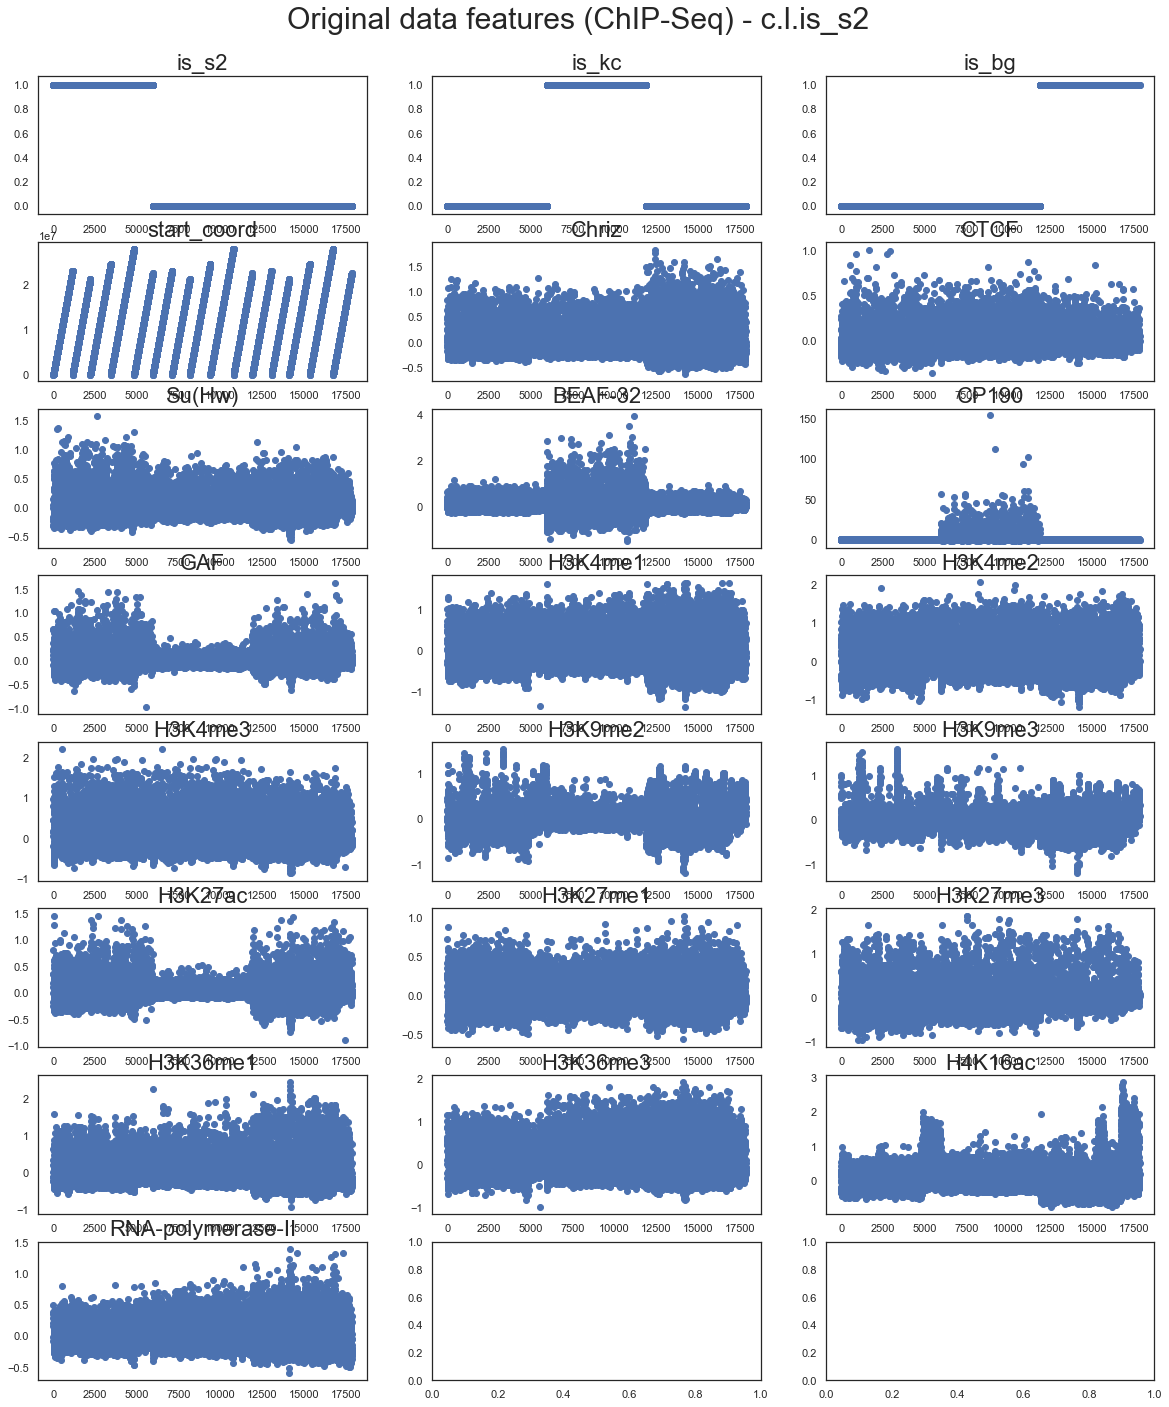

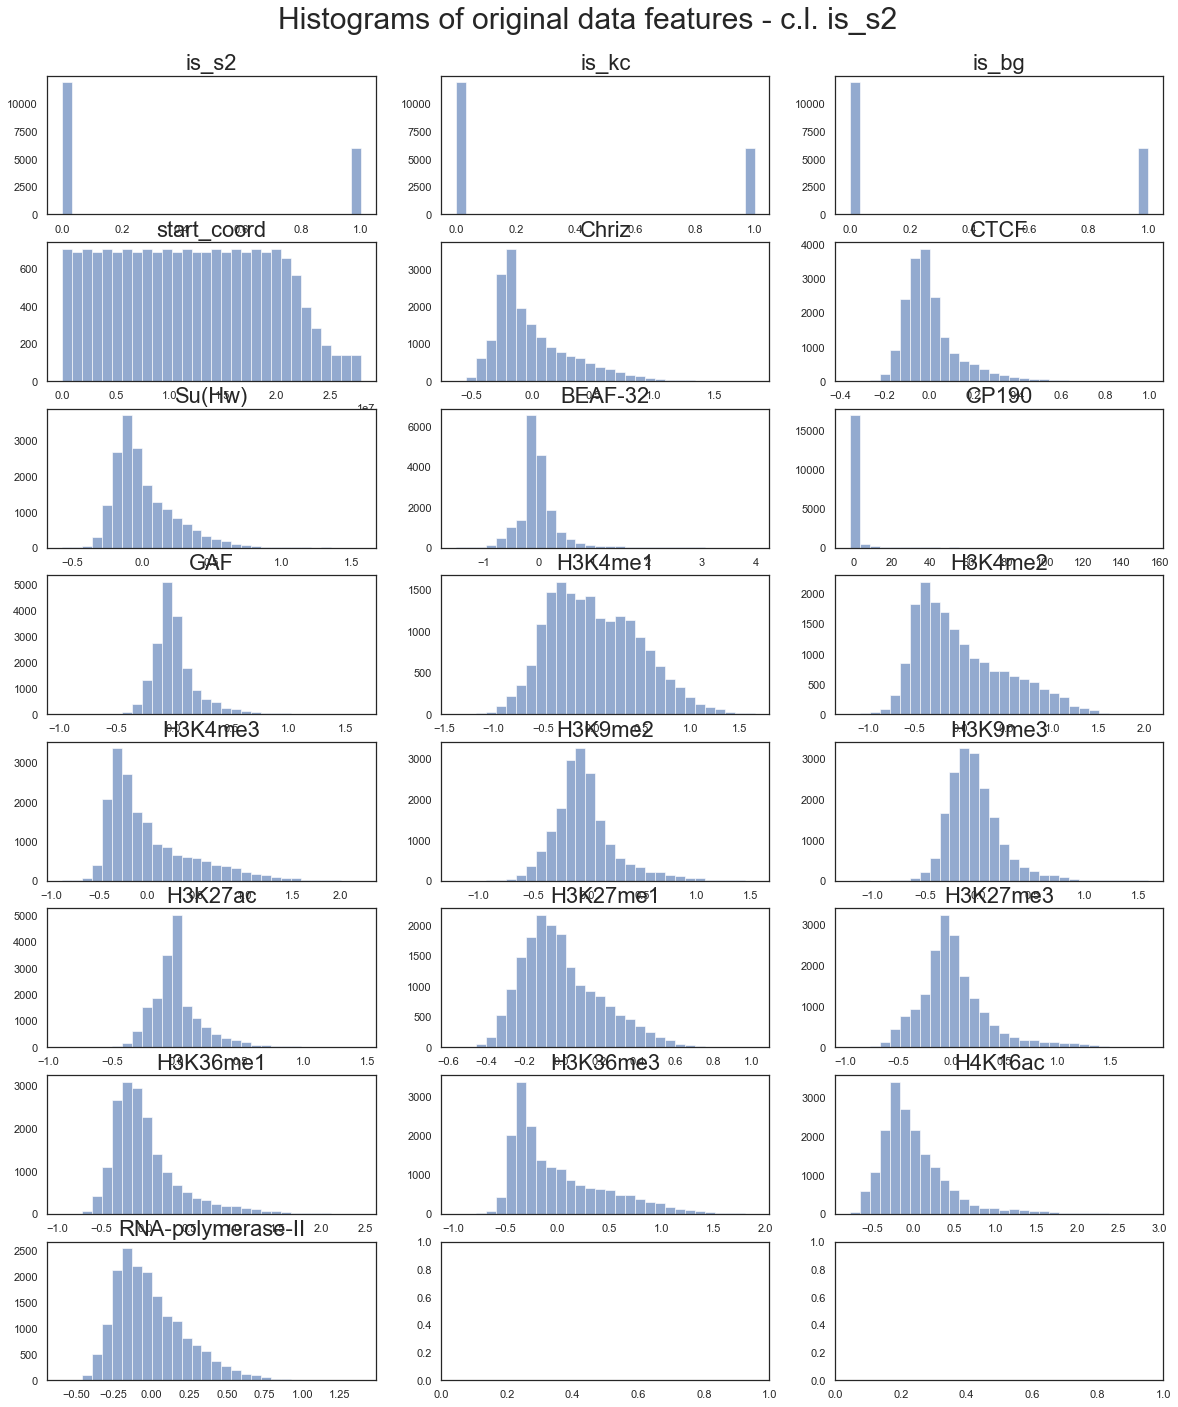

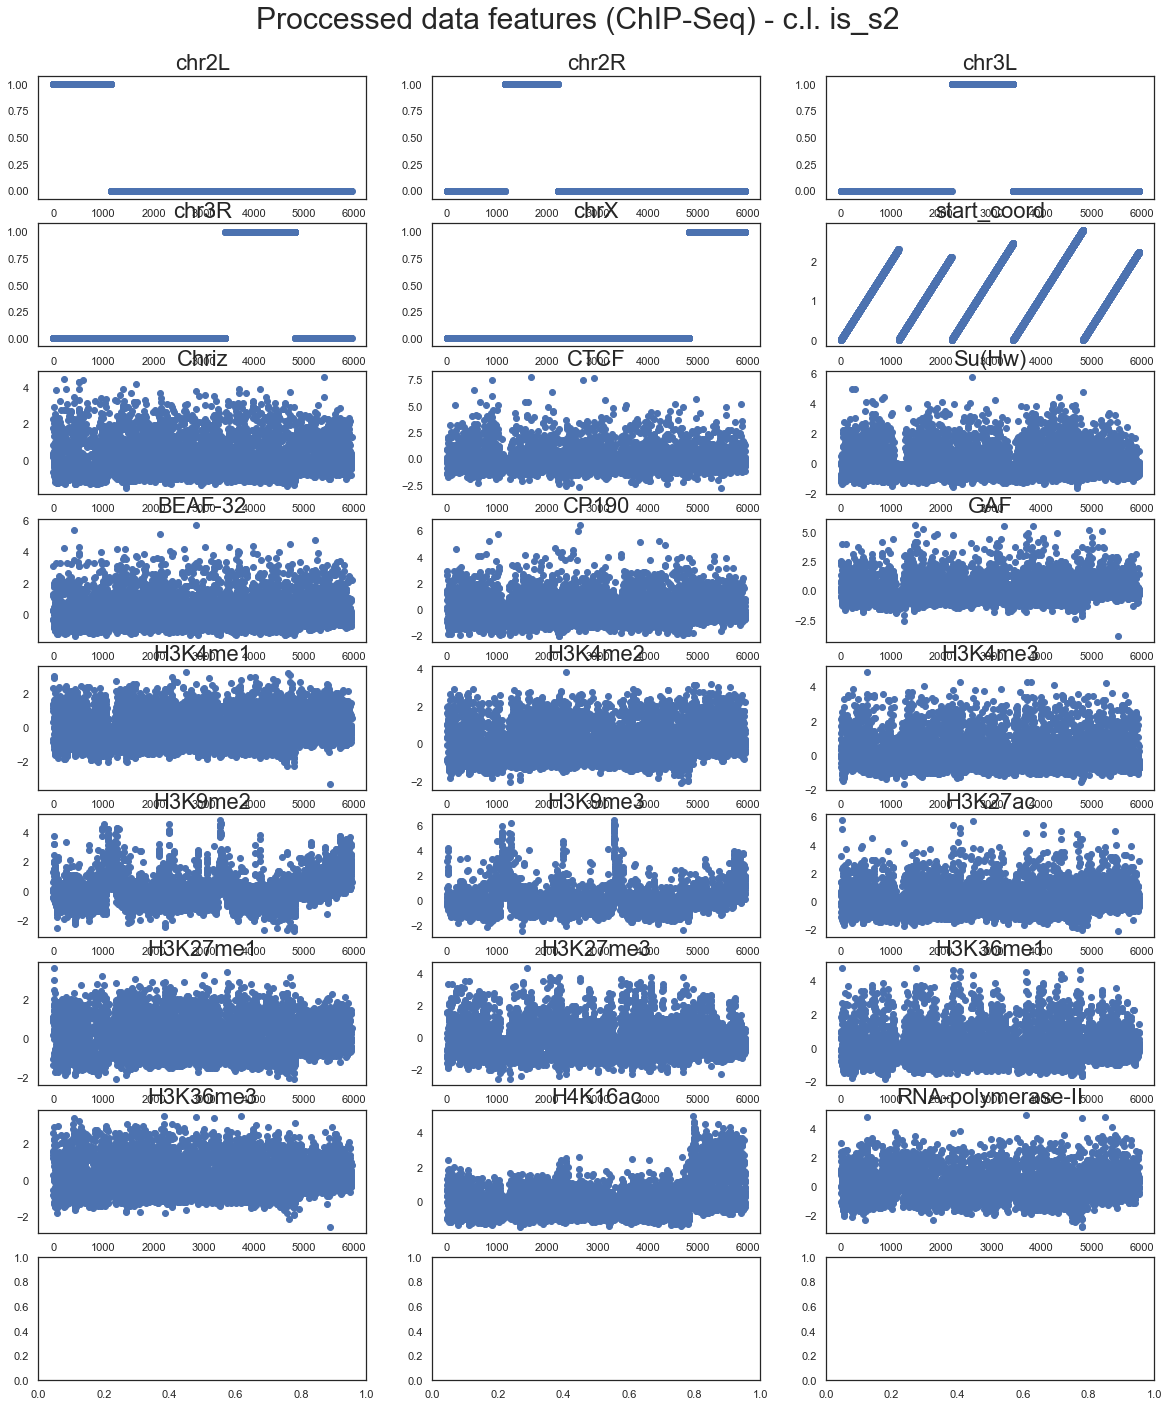

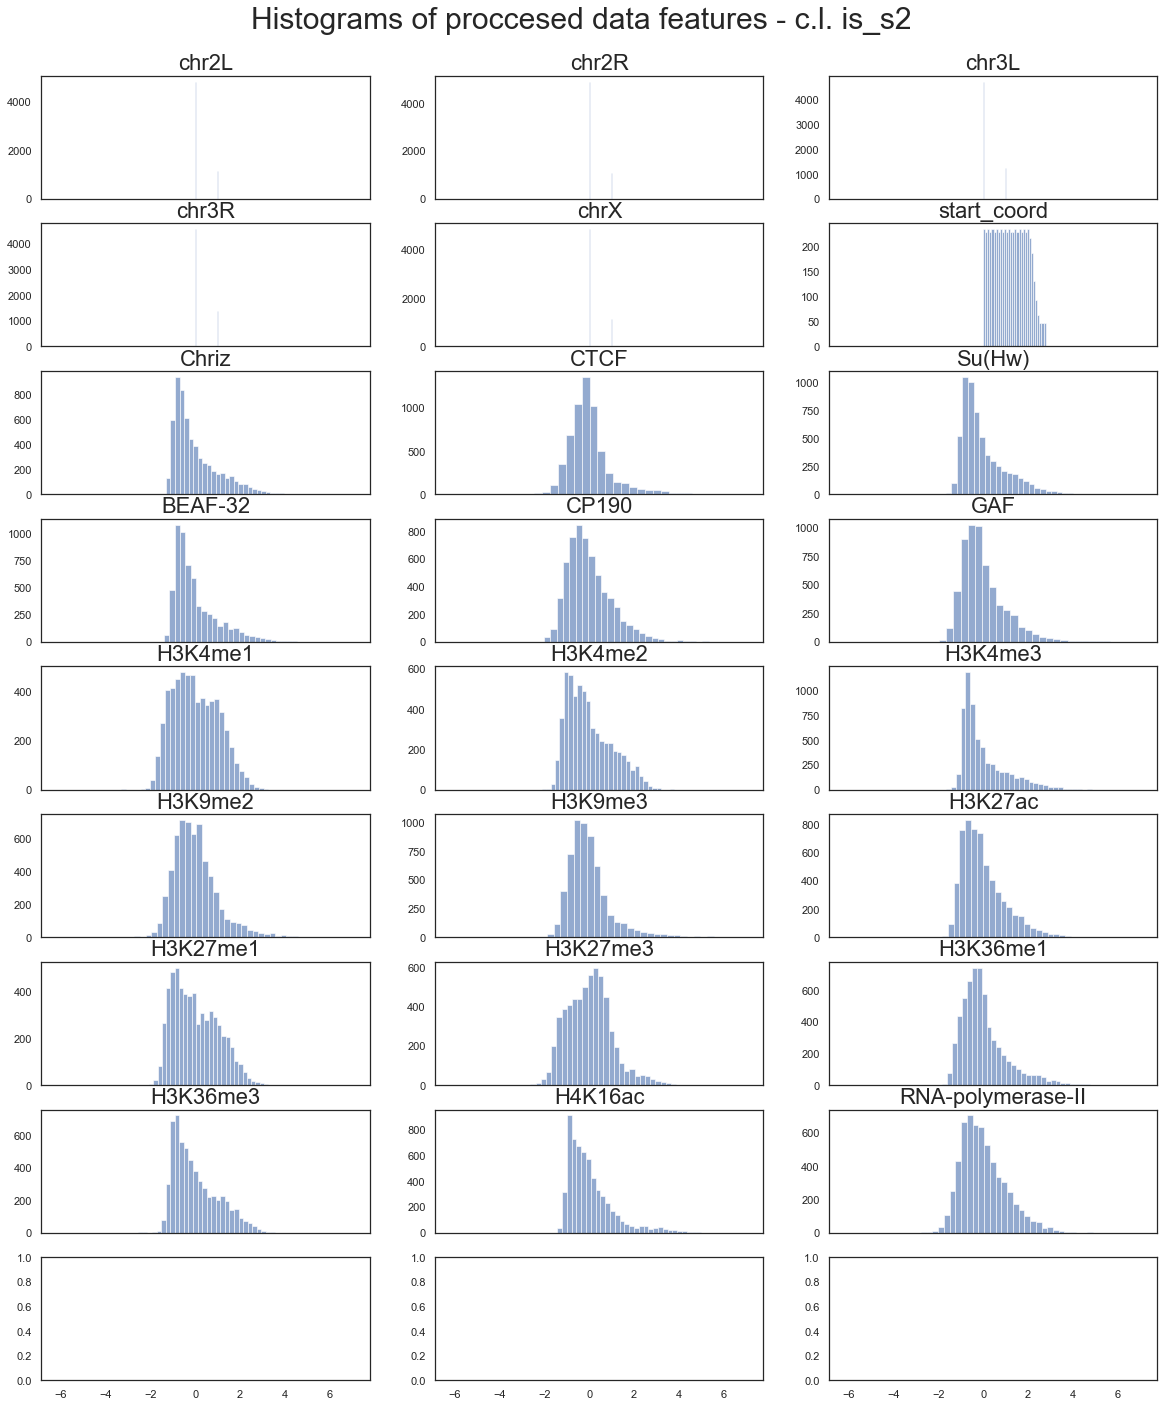

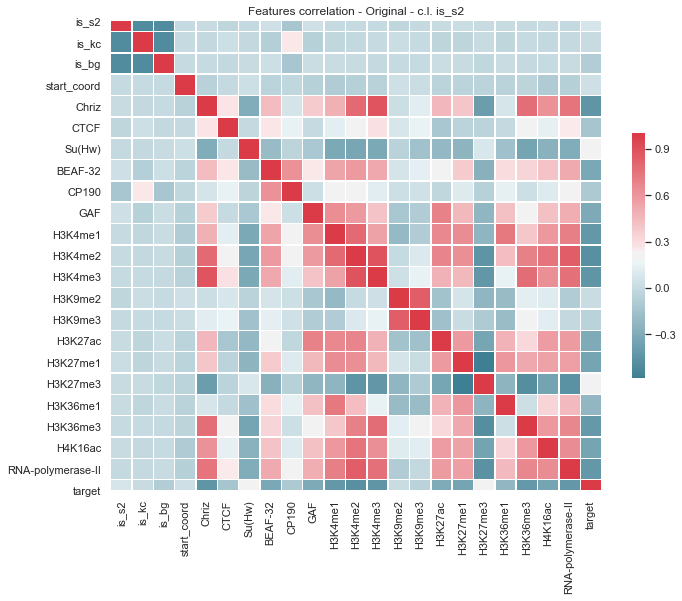

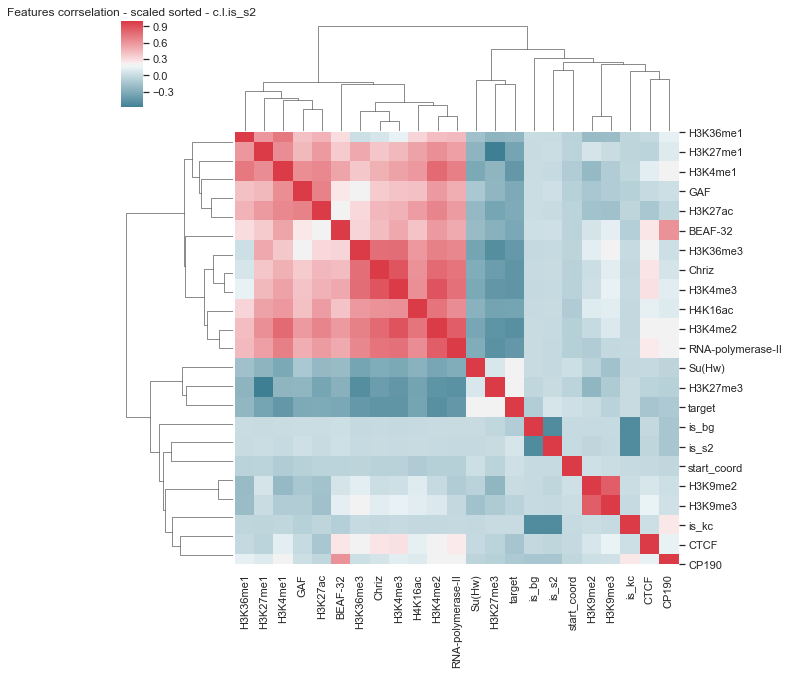

is_s2                0.068995
is_kc                0.006377
is_bg               -0.075372
start_coord          0.036987
Chriz               -0.435195
CTCF                -0.134135
Su(Hw)               0.189629
BEAF-32             -0.318613
CP190               -0.105750
GAF                 -0.306469
H3K4me1             -0.417050
H3K4me2             -0.468518
H3K4me3             -0.438623
H3K9me2              0.017396
H3K9me3             -0.045845
H3K27ac             -0.299087
H3K27me1            -0.342611
H3K27me3             0.199935
H3K36me1            -0.220909
H3K36me3            -0.410151
H4K16ac             -0.345961
RNA-polymerase-II   -0.415684
target               1.000000
Name: target, dtype: float64 Index(['H3K4me2', 'H3K4me3', 'Chriz', 'H3K4me1', 'RNA-polymerase-II',
       'H3K36me3', 'H4K16ac', 'H3K27me1', 'BEAF-32', 'GAF', 'H3K27ac',
       'H3K36me1', 'CTCF', 'CP190', 'is_bg', 'H3K9me3', 'is_kc', 'H3K9me2',
       'start_coord', 'is_s2', 'Su(Hw)', 'H3K27me3', 'target'],


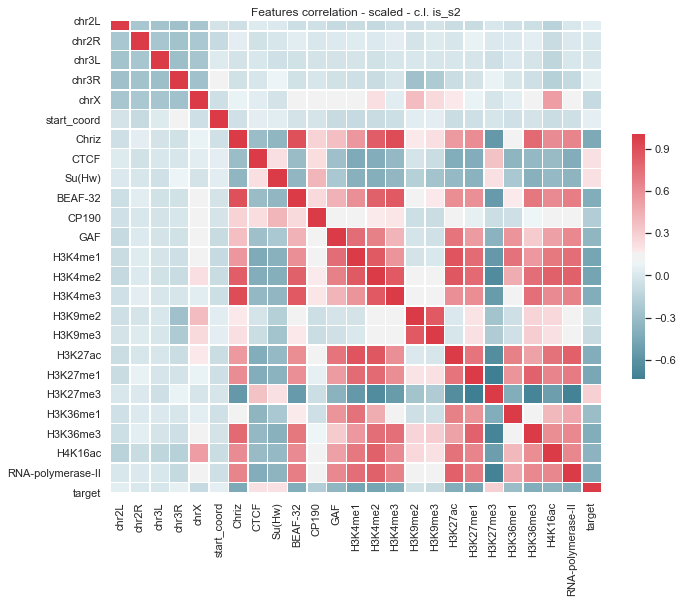

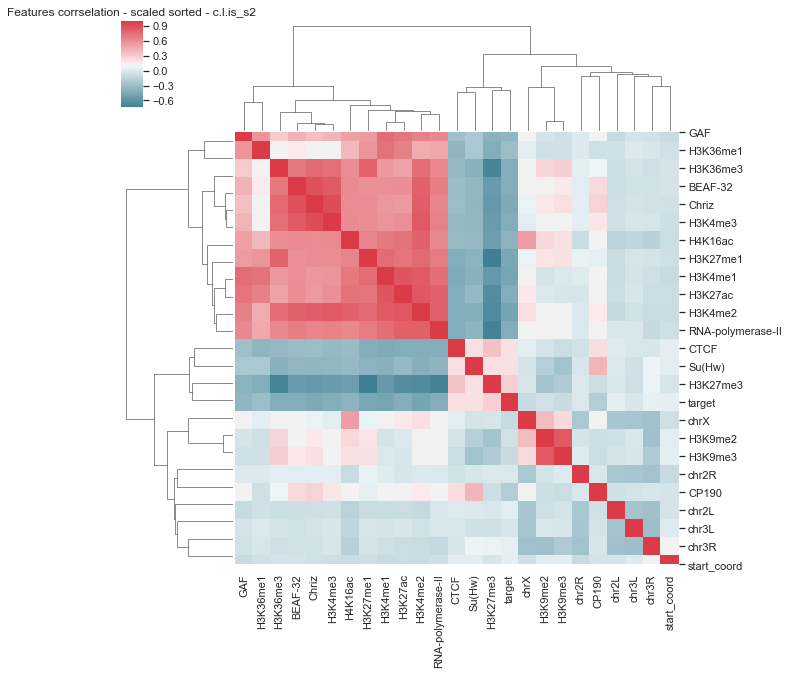

chr2L                0.040893
chr2R               -0.001248
chr3L               -0.016377
chr3R                0.063608
chrX                -0.092044
start_coord          0.051515
Chriz               -0.435518
CTCF                 0.208482
Su(Hw)               0.215525
BEAF-32             -0.412301
CP190               -0.180716
GAF                 -0.342976
H3K4me1             -0.465251
H3K4me2             -0.475649
H3K4me3             -0.413663
H3K9me2             -0.042617
H3K9me3             -0.085199
H3K27ac             -0.405127
H3K27me1            -0.453703
H3K27me3             0.294239
H3K36me1            -0.296120
H3K36me3            -0.415567
H4K16ac             -0.366379
RNA-polymerase-II   -0.407321
target               1.000000
Name: target, dtype: float64 Index(['H3K4me2', 'H3K4me1', 'H3K27me1', 'Chriz', 'H3K36me3', 'H3K4me3',
       'BEAF-32', 'RNA-polymerase-II', 'H3K27ac', 'H4K16ac', 'GAF', 'H3K36me1',
       'CP190', 'chrX', 'H3K9me3', 'H3K9me2', 'chr3L', 'chr2R', 'chr

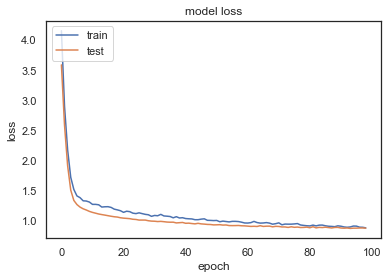

TEST WMSE =  0.8907295803894474
x_val.shape = (595, 6, 24)
y_val.shape = (595,)
x_train.shape = (3963, 6, 24)
y_train.shape = (3963,)
Train... with 
Epoch 00084: early stopping
duration: 15.54678201675415


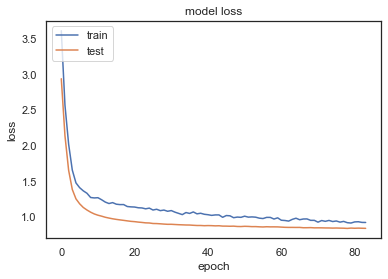

TEST WMSE =  0.843105074616593
x_val.shape = (595, 6, 24)
y_val.shape = (595,)
x_train.shape = (3964, 6, 24)
y_train.shape = (3964,)
Train... with 
Epoch 00092: early stopping
duration: 17.429925203323364


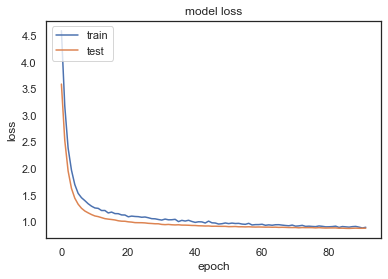

TEST WMSE =  0.8706401181865481
TEST MEAN WMSE =  0.8706401181865481


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
use_chr_onehotenc = True
use_coord_scale = True
    
    

data_csv = "_example_results_old18_bioset_1_exps_21_04_20.csv"

num_experements = 1

cell_line = 'is_s2' #  'all' #  'is_bg' # 'all' # 'is_s2' # cell_line one of: 'is_s2', 'is_kc', 'is_bg',  or 'all'


bioset = None  # bioset: defines the biological features to use. 
               #  If bioset is None, use all availible features
    

# bioset = [ 
#     'H3K4me2', #  'ISWI',
#     'Chriz',
#     'WDS', # 'MRG15',
#     'H3K79me3', #  'RNA-polymerase-II',
#              'H1', # 'H3K27me3',
#                'is_s2', 'is_kc', 'is_bg', 
#             'chrN', 
#             'start_coord',
#         ]

# bioset = [
# 'Chriz',
# 'CTCF',
# 'H3K27ac',
# 'H3K27me3',
# 'Su(Hw)',
#             'is_s2', 'is_kc', 'is_bg', 
#             'chrN', 
#             'start_coord',
# ]

# bioset = [            
#             'Chriz',
#             'RNA-polymerase-II',
#             'H1',
#             'H3K27me3',
#             'ISWI',
#             'H3K4me2',
#             'MRG15',
#             'WDS',
#             'H3K79me3',
#             'is_s2', 'is_kc', 'is_bg', 
#             'chrN', 
#             'start_coord',
#         ]

data_path_18features = '../data/epigenetics/s2_kc_bg_scaled_18_features.csv'
# data_path_35features = '../data/epigenetics/s2_kc_bg_scaled_34_overlap_features_2901.csv'
data_path = data_path_18features


target_path = "../data/epigenetics/s2_kc_bg_clean_gamma_2901.csv"  # "../data/epigenetics/s2_kc_bg_clean_gamma.csv"
index_col = 0


random_state = 16 # None  # Shuffle the data splittings

batch_size = 160 
sequenc_len_list =  [6] # , 5, 6, 8 ] ,# 
num_lstm_units = 64 
n_epochs_max = 364 
num_folds = 3


file_path = "./exps" + data_csv


# eval_models_df_1_all_5b_10x, eval_models_df_drop_all_5b_10x, eval_models_df_together, \
#     data_scaled_clean, target_clean, \
#     feature_score_1, feature_score_drop

eval_models_df_1_10x_old18, eval_models_df_drop_10x_old18, eval_models_df_together_10x_old18, \
            mean_together_10x_old18, std_together_10x_old18, feature_score_1, feature_score_drop, \
            data_scaled_clean, target_clean, = main_analysis(data_path,  
                                                       cell_line, 
                                                       bioset, 
                                                       num_experements,
                                                       sequenc_len_list = [6], 
                                                       num_lstm_units = 6,
                                                       num_folds = num_folds,
                                                       batch_size = batch_size,
                                                       do_only_1_feature_exps = False, 
                                                       do_drop_1_feature_exps = False,
                                                       do_all_together = True,
                                                       use_chr_onehotenc = use_chr_onehotenc,
                                                       use_coord_scale=use_coord_scale,
                                                       verbose=True)

# mean_together_3x_top, std_together_3x_top
# mean_together_10x_old18, std_together_3x_old5


In [52]:
! ls ../data/epigenetics

s2_kc_bg_clean_gamma_2901.csv        s2_kc_bg_scaled_18_features_2901.csv
s2_kc_bg_scaled_18_features.csv


In [53]:
 eval_models_df_together_10x_old18 

,exper_num,sequenc_len,num_lstm_units,n_epochs,weighted_mse_test_11,weighted_mse_train_11,weighted_mse_val_11,weighted_mse_test_const_11,batch_size,duration,missing_feature
0,0,6.0,6.0,99.000000,0.890730,0.784514,0.872831,1.613357,160.0,16.897934,-1.0
1,0,6.0,6.0,84.000000,0.843105,0.799304,0.837060,1.669410,160.0,15.546782,-1.0
2,0,6.0,6.0,92.000000,0.870640,0.782830,0.877132,1.613278,160.0,17.429925,-1.0
3,mean,6.0,6.0,91.666667,0.868158,0.788883,0.862341,1.632015,160.0,16.624880,-1.0
4,std,0.0,0.0,4.525647,0.015232,0.008333,0.020264,0.028578,0.0,0.944865,0.0


In [ ]:
use_chr_onehotenc = True
use_coord_scale = True
    
    

data_csv = "_example_results_old18_bioset_10_exps_21_04_20.csv"

num_experements = 10

cell_line = 'is_s2' #  'all' #  'is_bg' # 'all' # 'is_s2' # cell_line one of: 'is_s2', 'is_kc', 'is_bg',  or 'all'


bioset = None  # bioset: defines the biological features to use. 
               #  If bioset is None, use all availible features
    

# bioset = [ 
#     'H3K4me2', #  'ISWI',
#     'Chriz',
#     'WDS', # 'MRG15',
#     'H3K79me3', #  'RNA-polymerase-II',
#              'H1', # 'H3K27me3',
#                'is_s2', 'is_kc', 'is_bg', 
#             'chrN', 
#             'start_coord',
#         ]

# bioset = [
# 'Chriz',
# 'CTCF',
# 'H3K27ac',
# 'H3K27me3',
# 'Su(Hw)',
#             'is_s2', 'is_kc', 'is_bg', 
#             'chrN', 
#             'start_coord',
# ]

# bioset = [            
#             'Chriz',
#             'RNA-polymerase-II',
#             'H1',
#             'H3K27me3',
#             'ISWI',
#             'H3K4me2',
#             'MRG15',
#             'WDS',
#             'H3K79me3',
#             'is_s2', 'is_kc', 'is_bg', 
#             'chrN', 
#             'start_coord',
#         ]

data_path_18features = '../data/epigenetics/s2_kc_bg_scaled_18_features.csv'
# data_path_35features = '../data/epigenetics/s2_kc_bg_scaled_34_overlap_features_2901.csv'
data_path = data_path_18features


target_path = "../data/epigenetics/s2_kc_bg_clean_gamma_2901.csv"  # "../data/epigenetics/s2_kc_bg_clean_gamma.csv"
index_col = 0


random_state = 16 # None  # Shuffle the data splittings

batch_size = 60 
sequenc_len_list =  [6] # , 5, 6, 8 ] ,# 
num_lstm_units = 64 
n_epochs_max = 364 
num_folds = 5


file_path = "./exps" + data_csv


# eval_models_df_1_all_5b_10x, eval_models_df_drop_all_5b_10x, eval_models_df_together, \
#     data_scaled_clean, target_clean, \
#     feature_score_1, feature_score_drop

eval_models_df_1_10x_old18, eval_models_df_drop_10x_old18, eval_models_df_together_10x_old18, \
            mean_together_10x_old18, std_together_10x_old18, feature_score_1, feature_score_drop, \
            data_scaled_clean, target_clean, = main_analysis(data_path,  
                                                       cell_line, 
                                                       bioset, 
                                                       num_experements,
                                                       sequenc_len_list = [6], 
                                                       num_lstm_units = 6,
                                                       num_folds = num_folds,
                                                       batch_size = batch_size,
                                                       do_only_1_feature_exps = False, 
                                                       do_drop_1_feature_exps = False,
                                                       do_all_together = True,
                                                       use_chr_onehotenc = use_chr_onehotenc,
                                                       use_coord_scale=use_coord_scale,
                                                       verbose=True)

# mean_together_3x_top, std_together_3x_top
# mean_together_10x_old18, std_together_3x_old5


In [54]:
eval_models_df_together_10x_old18 

,exper_num,sequenc_len,num_lstm_units,n_epochs,weighted_mse_test_11,weighted_mse_train_11,weighted_mse_val_11,weighted_mse_test_const_11,batch_size,duration,missing_feature
0,0,6.0,6.0,99.000000,0.890730,0.784514,0.872831,1.613357,160.0,16.897934,-1.0
1,0,6.0,6.0,84.000000,0.843105,0.799304,0.837060,1.669410,160.0,15.546782,-1.0
2,0,6.0,6.0,92.000000,0.870640,0.782830,0.877132,1.613278,160.0,17.429925,-1.0
3,mean,6.0,6.0,91.666667,0.868158,0.788883,0.862341,1.632015,160.0,16.624880,-1.0
4,std,0.0,0.0,4.525647,0.015232,0.008333,0.020264,0.028578,0.0,0.944865,0.0


data.shape =  (17850, 23)
column names = ['is_s2' 'is_kc' 'is_bg' 'chrN' 'start_coord' 'Chriz' 'CTCF' 'Su(Hw)'
 'BEAF-32' 'CP190' 'GAF' 'H3K4me1' 'H3K4me2' 'H3K4me3' 'H3K9me2' 'H3K9me3'
 'H3K27ac' 'H3K27me1' 'H3K27me3' 'H3K36me1' 'H3K36me3' 'H4K16ac'
 'RNA-polymerase-II']
Using cell line: is_s2
Scaling of the features: Index(['Chriz', 'CTCF', 'Su(Hw)', 'BEAF-32', 'CP190', 'GAF', 'H3K4me1',
       'H3K4me2', 'H3K4me3', 'H3K9me2', 'H3K9me3', 'H3K27ac', 'H3K27me1',
       'H3K27me3', 'H3K36me1', 'H3K36me3', 'H4K16ac', 'RNA-polymerase-II'],
      dtype='object')
Using chromosome One Hot Encoding: ['chr2L' 'chr2R' 'chr3L' 'chr3R' 'chrX']
proccessed data.shape = (5950, 24)
original target.shape = (17850, 6)
target.columns = Index(['is_s2', 'is_kc', 'is_bg', 'chrN', 'start_coord', 'gamma'], dtype='object')
target.shape = (5950, 3)
target.column = Index(['chrN', 'start_coord', 'gamma'], dtype='object')
data_original.head =    is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw

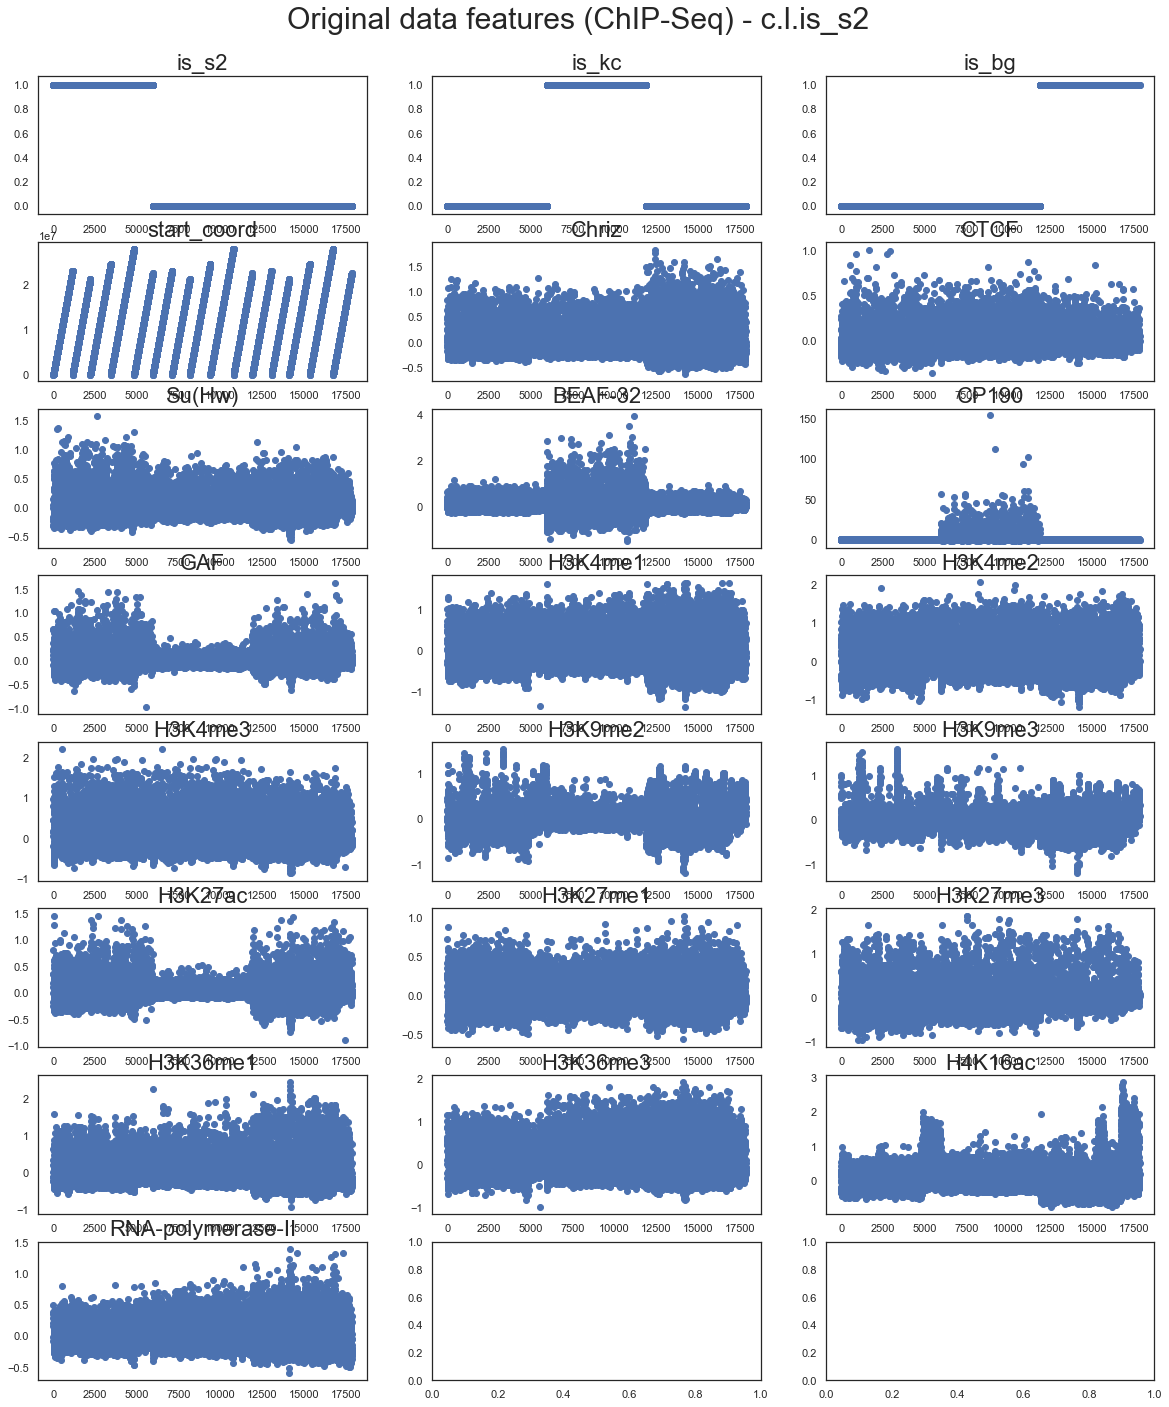

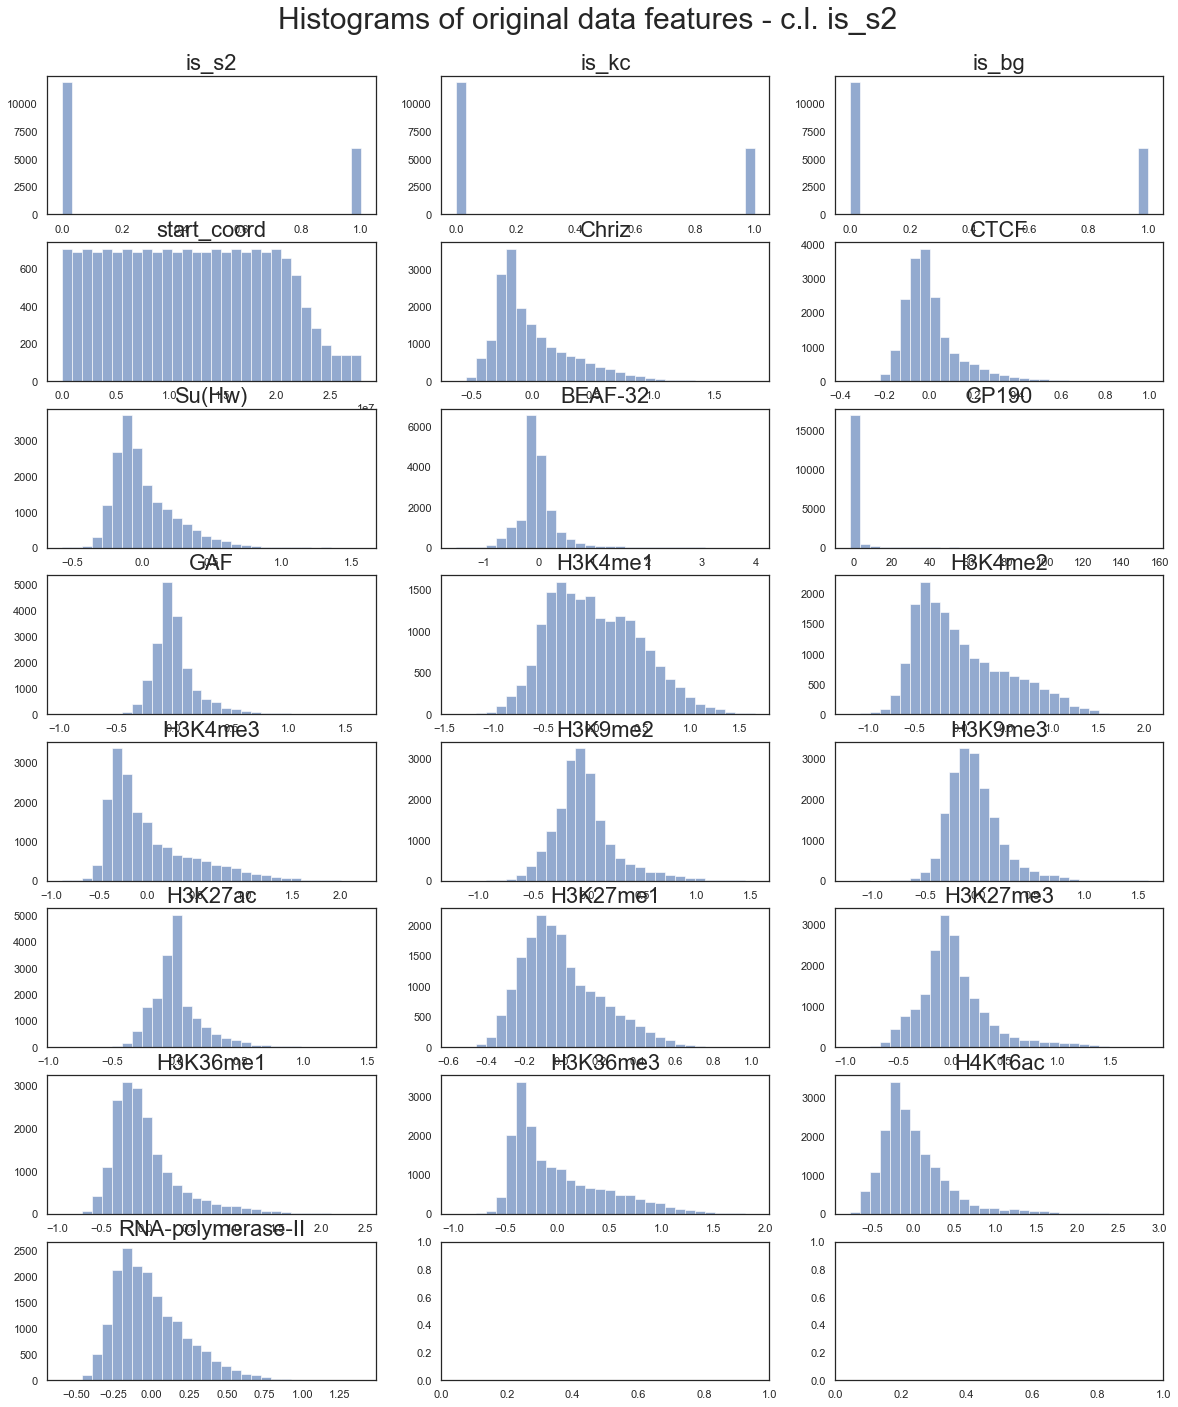

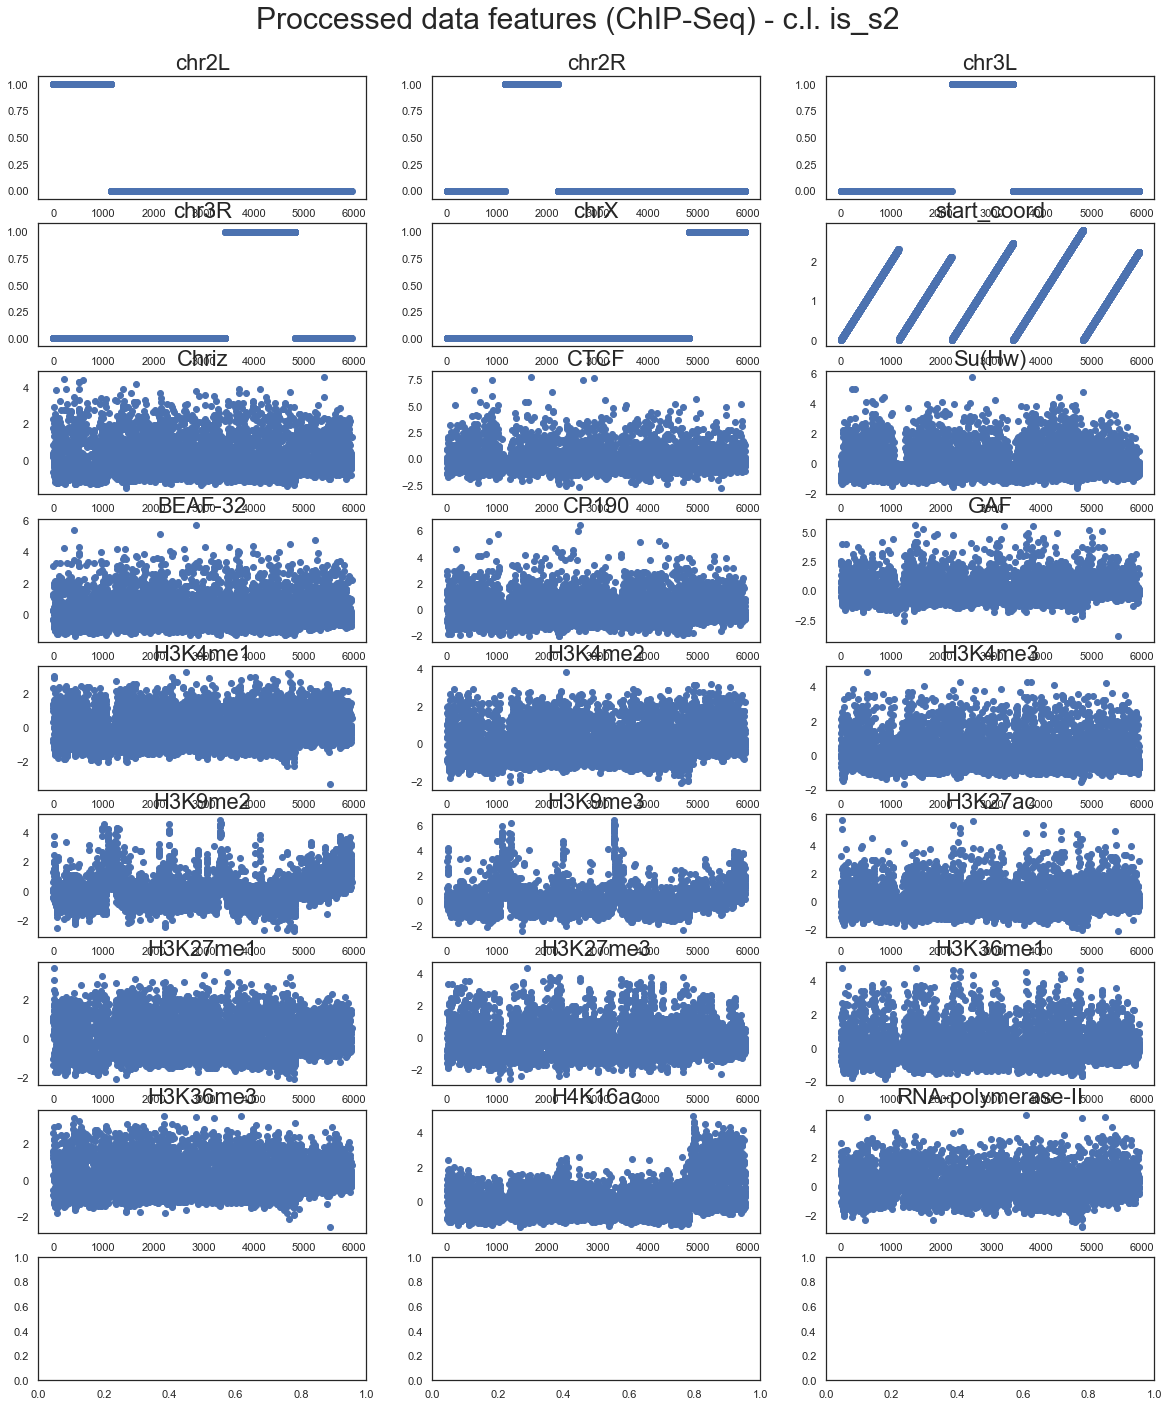

In [ ]:
use_chr_onehotenc = True
use_coord_scale = True
    
    

data_csv = "_example_results_old18_bioset_10_exps_21_04_20.csv"

num_experements = 1

cell_line = 'is_s2' #  'all' #  'is_bg' # 'all' # 'is_s2' # cell_line one of: 'is_s2', 'is_kc', 'is_bg',  or 'all'


bioset = None  # bioset: defines the biological features to use. 
               #  If bioset is None, use all availible features
    

# bioset = [ 
#     'H3K4me2', #  'ISWI',
#     'Chriz',
#     'WDS', # 'MRG15',
#     'H3K79me3', #  'RNA-polymerase-II',
#              'H1', # 'H3K27me3',
#                'is_s2', 'is_kc', 'is_bg', 
#             'chrN', 
#             'start_coord',
#         ]

# bioset = [
# 'Chriz',
# 'CTCF',
# 'H3K27ac',
# 'H3K27me3',
# 'Su(Hw)',
#             'is_s2', 'is_kc', 'is_bg', 
#             'chrN', 
#             'start_coord',
# ]

# bioset = [            
#             'Chriz',
#             'RNA-polymerase-II',
#             'H1',
#             'H3K27me3',
#             'ISWI',
#             'H3K4me2',
#             'MRG15',
#             'WDS',
#             'H3K79me3',
#             'is_s2', 'is_kc', 'is_bg', 
#             'chrN', 
#             'start_coord',
#         ]

data_path_18features = '../data/epigenetics/s2_kc_bg_scaled_18_features.csv'
# data_path_35features = '../data/epigenetics/s2_kc_bg_scaled_34_overlap_features_2901.csv'
data_path = data_path_18features


target_path = "../data/epigenetics/s2_kc_bg_clean_gamma_2901.csv"  # "../data/epigenetics/s2_kc_bg_clean_gamma.csv"
index_col = 0


random_state = 16 # None  # Shuffle the data splittings

batch_size = 60 
sequenc_len_list =  [6] # , 5, 6, 8 ] ,# 
num_lstm_units = 16 
n_epochs_max = 364 
num_folds = 3


file_path = "./exps" + data_csv


# eval_models_df_1_all_5b_10x, eval_models_df_drop_all_5b_10x, eval_models_df_together, \
#     data_scaled_clean, target_clean, \
#     feature_score_1, feature_score_drop

eval_models_df_1_10x_old18, eval_models_df_drop_10x_old18, eval_models_df_together_10x_old18, \
            mean_together_10x_old18, std_together_10x_old18, feature_score_1, feature_score_drop, \
            data_scaled_clean, target_clean, = main_analysis(data_path,  
                                                       cell_line, 
                                                       bioset, 
                                                       num_experements,
                                                       sequenc_len_list = [6], 
                                                       num_lstm_units = 6,
                                                       num_folds = num_folds,
                                                       batch_size = batch_size,
                                                       do_only_1_feature_exps = False, 
                                                       do_drop_1_feature_exps = False,
                                                       do_all_together = True,
                                                       use_chr_onehotenc = use_chr_onehotenc,
                                                       use_coord_scale=use_coord_scale,
                                                       verbose=True)


eval_models_df_together_10x_old18 

In [ ]:
eval_models_df_together_10x_old18 